In [24]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
# for data scaling and splitting
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# for neural net
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
# for evaluation
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# data plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
data = pd.read_csv("data/combined_expression.csv")
data['cluster'].replace([1, 2],[0, 1],inplace=True)
data.head()

,CELL_LINE_NAME,cluster,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,C6orf10,TMEM225,NOTCH4,PBX2,AGER,RNF5,AGPAT1,DFNB59,PRRT1,FKBPL
0,1240123,1,8.319417,3.111183,9.643558,4.757258,3.919757,3.602185,3.329644,9.076950,...,3.085394,3.462811,3.339030,4.614897,3.395845,3.419193,3.971646,3.729310,3.320022,6.447316
1,1240131,0,7.611268,2.704739,10.276079,3.650299,3.481567,3.145538,3.565127,7.861068,...,2.801456,2.985889,3.180068,5.415729,3.299858,3.028414,3.877889,3.911516,3.379405,4.729557
2,1240132,0,7.678658,2.845781,10.180954,3.573048,3.431235,3.090781,4.116643,8.121190,...,2.934962,2.952937,3.164655,5.707506,3.434295,2.961345,4.272194,3.085696,3.002557,5.653588
3,1240134,0,3.265063,3.063746,10.490285,3.340791,3.676912,3.512821,3.873922,8.790851,...,3.041839,3.398847,3.106710,5.773963,3.412641,3.136110,4.422262,3.522122,3.509437,5.953242
4,1240140,0,7.090138,2.988043,10.264692,4.119555,3.432585,3.308033,3.318371,6.927761,...,3.028787,3.225982,3.275820,5.334283,3.864678,3.259242,3.840581,5.809553,3.674587,5.577503


In [26]:
data.shape

(541, 16384)

In [27]:
selected_genes = pd.read_csv('cleaned/boruta.csv')
selected_genes = selected_genes.values.tolist()
selected_genes = list(itertools.chain(*selected_genes))

In [28]:
# retrieving proper columns
X = data.loc[:, selected_genes]
y = data['cluster'].values
# scaling the data
scalar = MinMaxScaler()
x_scaled = scalar.fit_transform(X)
# splitting data (20% test, 80% train)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)
sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

# K-Folds Evaluation Function

In [29]:
def cv_eval(model, n_folds, X, y):
    """K-fold validation function for evaluation of a Keras model.
    Arguments:
        model: the model to evaluate.
        n_folds (int): the number of cross-folds.
        X: values of the feature variables.
        y: values of the classification.
    Returns:
        cms (list): confusion matrix for each cross-fold.
        histories (list): model metrics for each cross-fold.
        tprs (list): the True Positive Rate for each cross-fold.
        base_fpr (list): the cutoff points for the ROC curve.
    """
    kf = KFold(n_splits=n_folds)
    cms = []  # confusion matrix results
    histories = []  # for model analysis
    tprs = []  # for ROC analysis
    base_fpr = np.linspace(0, 1, 101)  # for ROC analysis

    for i_train, i_test in kf.split(X, y):
        X_train, X_test = X.iloc[i_train].values, X.iloc[i_test].values
        y_train, y_test = y[i_train], y[i_test]
        # recording model metrics and confusion matrix
        histories.append(model.fit(X_train, y_train, validation_data=(X_test, y_test)))
        cms.append(confusion_matrix(y_test, model.predict(X_test)))
        # recording for auc
        y_score = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.
        tprs.append(tpr)

    return cms, histories, tprs, base_fpr

# Confusion Matrix Plotting Function

In [55]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True, cbar=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(4, 3), dpi=200)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names, rotation=90, verticalalignment='center')
#         plt.yticks([], ['', ''])

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    if cbar:
        plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    plt.show()

    return fig

# 1 Hidden Layer

In [31]:
def hidden1(optimizer='sgd', init='normal', dropout=0.3, neurons=100):
    model = Sequential()
    # hidden layer
    model.add(Dense(neurons, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-3)
                   ))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    # output layer
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [32]:
model1 = KerasClassifier(build_fn=hidden1, epochs=25, batch_size=16)
cm_results1, history1, tpr1, base_fpr1 = cv_eval(model1, 5, X, y)

Train on 432 samples, validate on 109 samples
Epoch 1/25
432/432 [==============================] - 2s 5ms/sample - loss: 0.7378 - accuracy: 0.7060 - val_loss: 1.0098 - val_accuracy: 0.7615
Epoch 2/25
432/432 [==============================] - 0s 535us/sample - loss: 0.6523 - accuracy: 0.7894 - val_loss: 0.5764 - val_accuracy: 0.8532
Epoch 3/25
432/432 [==============================] - 0s 540us/sample - loss: 0.5648 - accuracy: 0.8264 - val_loss: 0.4304 - val_accuracy: 0.8899
Epoch 4/25
432/432 [==============================] - 0s 485us/sample - loss: 0.5812 - accuracy: 0.8241 - val_loss: 0.3611 - val_accuracy: 0.9266
Epoch 5/25
432/432 [==============================] - 0s 478us/sample - loss: 0.5448 - accuracy: 0.8356 - val_loss: 0.4139 - val_accuracy: 0.8899
Epoch 6/25
432/432 [==============================] - 0s 473us/sample - loss: 0.5425 - accuracy: 0.8241 - val_loss: 0.4218 - val_accuracy: 0.8899
Epoch 7/25
432/432 [==============================] - 0s 464us/sample - loss: 0.

Epoch 6/25
433/433 [==============================] - 0s 648us/sample - loss: 0.4921 - accuracy: 0.8591 - val_loss: 0.6715 - val_accuracy: 0.8148
Epoch 7/25
433/433 [==============================] - 0s 620us/sample - loss: 0.4832 - accuracy: 0.8868 - val_loss: 0.6595 - val_accuracy: 0.7963
Epoch 8/25
433/433 [==============================] - 0s 648us/sample - loss: 0.4682 - accuracy: 0.8637 - val_loss: 0.6603 - val_accuracy: 0.8056
Epoch 9/25
433/433 [==============================] - 0s 635us/sample - loss: 0.4698 - accuracy: 0.8776 - val_loss: 0.6683 - val_accuracy: 0.8056
Epoch 10/25
433/433 [==============================] - 0s 631us/sample - loss: 0.4340 - accuracy: 0.8799 - val_loss: 0.6694 - val_accuracy: 0.8056
Epoch 11/25
433/433 [==============================] - 0s 636us/sample - loss: 0.4280 - accuracy: 0.9076 - val_loss: 0.7075 - val_accuracy: 0.7778
Epoch 12/25
433/433 [==============================] - 0s 620us/sample - loss: 0.4531 - accuracy: 0.8799 - val_loss: 0.660

In [33]:
cm1 = [[0, 0]]
k, l = 0, 0
for i in cm_results1:
    for j in cm_results1[0]:
        cm1[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm1 = np.array(cm1[0])

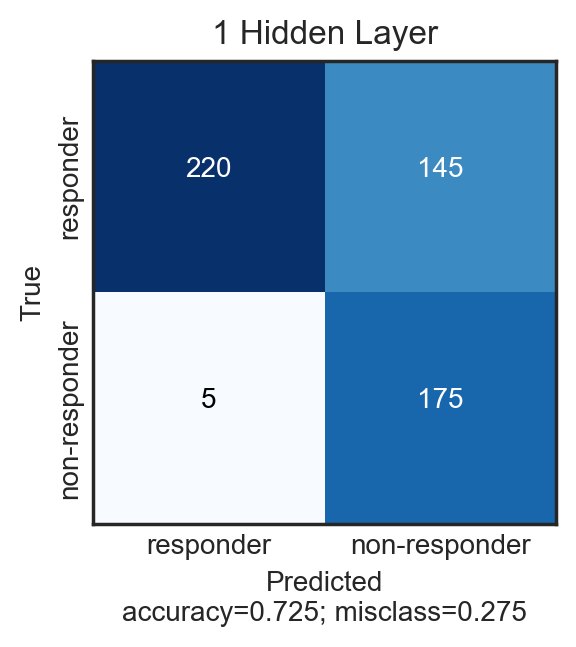

In [56]:
plt.rcParams.update({'font.size': 10})
cm_hidden1 = plot_confusion_matrix(cm1, ['responder', 'non-responder'], title='1 Hidden Layer', normalize=False, cbar=False)

# 5-Fold Validation for 5 Hidden Layers

In [35]:
def hidden5(optimizer='sgd', init='normal', dropout=0.3, neurons=100):
    model = Sequential()
    hidden_layers = len(selected_genes)
    # add 5 hidden layers
    for i in range(5):
        model.add(Dense(neurons, activation='relu',
                        kernel_regularizer=regularizers.l2(1e-3)
                       ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [36]:
model5 = KerasClassifier(build_fn=hidden5, epochs=25, batch_size=16)
cm_results5, history5, tprs5, base_fpr5 = cv_eval(model5, 5, X, y)

Train on 432 samples, validate on 109 samples
Epoch 1/25
432/432 [==============================] - 7s 16ms/sample - loss: 1.3108 - accuracy: 0.6181 - val_loss: 1.1154 - val_accuracy: 0.6697
Epoch 2/25
432/432 [==============================] - 0s 1ms/sample - loss: 1.1345 - accuracy: 0.7269 - val_loss: 1.9966 - val_accuracy: 0.3303
Epoch 3/25
432/432 [==============================] - 0s 948us/sample - loss: 1.1702 - accuracy: 0.7130 - val_loss: 1.0363 - val_accuracy: 0.8073
Epoch 4/25
432/432 [==============================] - 0s 943us/sample - loss: 1.1288 - accuracy: 0.7431 - val_loss: 0.9769 - val_accuracy: 0.7982
Epoch 5/25
432/432 [==============================] - 0s 917us/sample - loss: 1.1529 - accuracy: 0.7523 - val_loss: 0.9531 - val_accuracy: 0.7982
Epoch 6/25
432/432 [==============================] - 0s 929us/sample - loss: 1.0503 - accuracy: 0.7755 - val_loss: 0.8689 - val_accuracy: 0.9083
Epoch 7/25
432/432 [==============================] - 0s 912us/sample - loss: 1.0

433/433 [==============================] - 1s 1ms/sample - loss: 0.9732 - accuracy: 0.8360 - val_loss: 0.9294 - val_accuracy: 0.8426
Epoch 13/25
433/433 [==============================] - 1s 1ms/sample - loss: 0.9417 - accuracy: 0.8360 - val_loss: 0.9343 - val_accuracy: 0.8333
Epoch 14/25
433/433 [==============================] - 1s 1ms/sample - loss: 0.9861 - accuracy: 0.8314 - val_loss: 0.9416 - val_accuracy: 0.8333
Epoch 15/25
433/433 [==============================] - 1s 1ms/sample - loss: 0.9809 - accuracy: 0.8176 - val_loss: 0.9161 - val_accuracy: 0.8333
Epoch 16/25
433/433 [==============================] - 1s 1ms/sample - loss: 0.9386 - accuracy: 0.8360 - val_loss: 0.9215 - val_accuracy: 0.8519
Epoch 17/25
433/433 [==============================] - 1s 1ms/sample - loss: 0.9714 - accuracy: 0.8430 - val_loss: 0.9419 - val_accuracy: 0.8426
Epoch 18/25
433/433 [==============================] - 1s 1ms/sample - loss: 0.9408 - accuracy: 0.8406 - val_loss: 0.9378 - val_accuracy: 0.83

In [37]:
cm5 = [[0, 0]]
k, l = 0, 0
for i in cm_results5:
    for j in cm_results5[0]:
        cm5[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm5 = np.array(cm5[0])

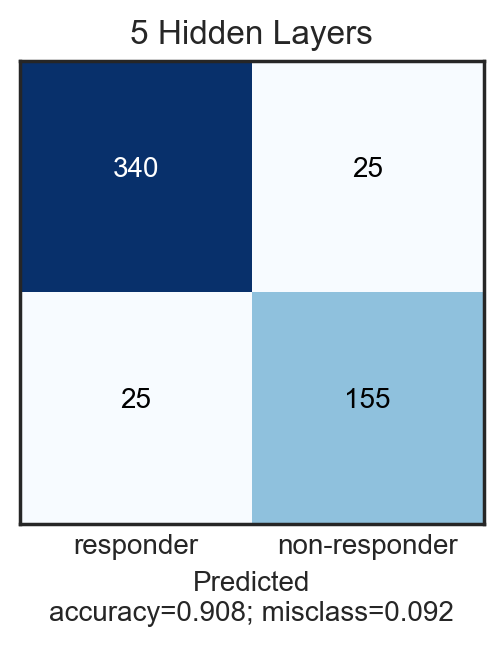

In [54]:
plt.rcParams.update({'font.size': 10})
cm_hidden5 = plot_confusion_matrix(cm5, ['responder', 'non-responder'], title='5 Hidden Layers', normalize=False, cbar=False)

# 10 Hidden Layers

In [39]:
def hidden10(optimizer='sgd', init='normal', dropout=0.3, neurons=100):
    model = Sequential()
    hidden_layers = len(selected_genes)
    # add 10 hidden layers
    for i in range(10):
        model.add(Dense(neurons, activation='relu',
                        kernel_regularizer=regularizers.l2(1e-3)
                       ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [40]:
model10 = KerasClassifier(build_fn=hidden10, epochs=25, batch_size=16)
cm_results10, history10, tprs10, base_fpr10 = cv_eval(model10, 5, X, y)

Train on 432 samples, validate on 109 samples
Epoch 1/25
432/432 [==============================] - 9s 22ms/sample - loss: 2.0136 - accuracy: 0.5046 - val_loss: 1.8962 - val_accuracy: 0.1009
Epoch 2/25
432/432 [==============================] - 1s 2ms/sample - loss: 1.8775 - accuracy: 0.5579 - val_loss: 1.7354 - val_accuracy: 0.7339
Epoch 3/25
432/432 [==============================] - 1s 2ms/sample - loss: 1.9529 - accuracy: 0.5116 - val_loss: 1.8028 - val_accuracy: 0.3394
Epoch 4/25
432/432 [==============================] - 1s 2ms/sample - loss: 1.8588 - accuracy: 0.5556 - val_loss: 1.7644 - val_accuracy: 0.6239
Epoch 5/25
432/432 [==============================] - 1s 2ms/sample - loss: 1.7684 - accuracy: 0.6366 - val_loss: 1.6655 - val_accuracy: 0.6972
Epoch 6/25
432/432 [==============================] - 1s 2ms/sample - loss: 1.7645 - accuracy: 0.6319 - val_loss: 1.5911 - val_accuracy: 0.7431
Epoch 7/25
432/432 [==============================] - 1s 2ms/sample - loss: 1.7507 - accu

Epoch 7/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.7441 - accuracy: 0.6651 - val_loss: 1.7070 - val_accuracy: 0.7130
Epoch 8/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.7080 - accuracy: 0.6790 - val_loss: 1.6453 - val_accuracy: 0.7315
Epoch 9/25
433/433 [==============================] - 1s 3ms/sample - loss: 1.6602 - accuracy: 0.7344 - val_loss: 1.5894 - val_accuracy: 0.7870
Epoch 10/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.6860 - accuracy: 0.7136 - val_loss: 1.5880 - val_accuracy: 0.8056
Epoch 11/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.6469 - accuracy: 0.7344 - val_loss: 1.5827 - val_accuracy: 0.8148
Epoch 12/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.6515 - accuracy: 0.7598 - val_loss: 1.5793 - val_accuracy: 0.8056
Epoch 13/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.5801 - accuracy: 0.8037 - val_loss: 1.5716 - val_accur

Epoch 13/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.6200 - accuracy: 0.7552 - val_loss: 1.5161 - val_accuracy: 0.8333
Epoch 14/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.5904 - accuracy: 0.7737 - val_loss: 1.5325 - val_accuracy: 0.8333
Epoch 15/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.5714 - accuracy: 0.8176 - val_loss: 1.5007 - val_accuracy: 0.8426
Epoch 16/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.5966 - accuracy: 0.7714 - val_loss: 1.5219 - val_accuracy: 0.8241
Epoch 17/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.5592 - accuracy: 0.7991 - val_loss: 1.5169 - val_accuracy: 0.8333
Epoch 18/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.5384 - accuracy: 0.8199 - val_loss: 1.5274 - val_accuracy: 0.8333
Epoch 19/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.5618 - accuracy: 0.8083 - val_loss: 1.5134 - val_ac

In [41]:
cm10 = [[0, 0]]
k, l = 0, 0
for i in cm_results10:
    for j in cm_results10[0]:
        cm10[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm10 = np.array(cm10[0])
cm10

array([[360,   5],
       [ 20, 160]])

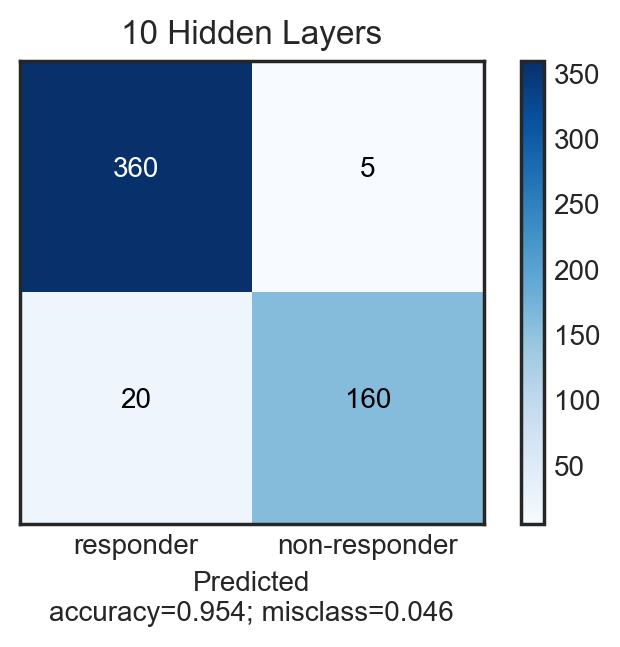

In [53]:
plt.rcParams.update({'font.size': 10})
cm_hidden10 = plot_confusion_matrix(cm10, ['responder', 'non-responder'], title='10 Hidden Layers', normalize=False)

# 15 Hidden Layers

In [57]:
def hidden15(optimizer='sgd', init='normal', dropout=0.3, neurons=100):
    model = Sequential()
    hidden_layers = len(selected_genes)
    # add 15 hidden layers
    for i in range(15):
        model.add(Dense(neurons, activation='relu',
                        kernel_regularizer=regularizers.l2(1e-3)
                       ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [58]:
model15 = KerasClassifier(build_fn=hidden15, epochs=25, batch_size=16)
cm_results15, history15, tprs15, base_fpr15 = cv_eval(model15, 5, X, y)

Train on 432 samples, validate on 109 samples
Epoch 1/25
432/432 [==============================] - 11s 25ms/sample - loss: 2.5730 - accuracy: 0.5139 - val_loss: 2.7047 - val_accuracy: 0.3303
Epoch 2/25
432/432 [==============================] - 1s 2ms/sample - loss: 2.5834 - accuracy: 0.5046 - val_loss: 2.7440 - val_accuracy: 0.3303
Epoch 3/25
432/432 [==============================] - 1s 2ms/sample - loss: 2.5201 - accuracy: 0.5347 - val_loss: 2.7666 - val_accuracy: 0.0734
Epoch 4/25
432/432 [==============================] - 1s 2ms/sample - loss: 2.5023 - accuracy: 0.5486 - val_loss: 2.7405 - val_accuracy: 0.0642
Epoch 5/25
432/432 [==============================] - 1s 2ms/sample - loss: 2.4780 - accuracy: 0.5509 - val_loss: 2.4343 - val_accuracy: 0.3853
Epoch 6/25
432/432 [==============================] - 1s 2ms/sample - loss: 2.4388 - accuracy: 0.5509 - val_loss: 2.2083 - val_accuracy: 0.6972
Epoch 7/25
432/432 [==============================] - 1s 2ms/sample - loss: 2.4702 - acc

Epoch 7/25
433/433 [==============================] - 1s 2ms/sample - loss: 2.6416 - accuracy: 0.5843 - val_loss: 2.5263 - val_accuracy: 0.6574
Epoch 8/25
433/433 [==============================] - 1s 3ms/sample - loss: 2.6548 - accuracy: 0.5219 - val_loss: 2.5308 - val_accuracy: 0.7130
Epoch 9/25
433/433 [==============================] - 1s 3ms/sample - loss: 2.6543 - accuracy: 0.5681 - val_loss: 2.5070 - val_accuracy: 0.7130
Epoch 10/25
433/433 [==============================] - 1s 3ms/sample - loss: 2.5850 - accuracy: 0.6074 - val_loss: 2.4794 - val_accuracy: 0.7315
Epoch 11/25
433/433 [==============================] - 1s 2ms/sample - loss: 2.5848 - accuracy: 0.6282 - val_loss: 2.4224 - val_accuracy: 0.7963
Epoch 12/25
433/433 [==============================] - 1s 2ms/sample - loss: 2.5778 - accuracy: 0.6282 - val_loss: 2.3930 - val_accuracy: 0.8148
Epoch 13/25
433/433 [==============================] - 1s 2ms/sample - loss: 2.5530 - accuracy: 0.6397 - val_loss: 2.3994 - val_accur

Epoch 13/25
433/433 [==============================] - 1s 2ms/sample - loss: 3.4984 - accuracy: 0.6536 - val_loss: 3.3658 - val_accuracy: 0.7500
Epoch 14/25
433/433 [==============================] - 1s 2ms/sample - loss: 3.4664 - accuracy: 0.6859 - val_loss: 3.3613 - val_accuracy: 0.7778
Epoch 15/25
433/433 [==============================] - 1s 2ms/sample - loss: 3.4576 - accuracy: 0.6882 - val_loss: 3.3370 - val_accuracy: 0.8056
Epoch 16/25
433/433 [==============================] - 1s 2ms/sample - loss: 3.4933 - accuracy: 0.6628 - val_loss: 3.3166 - val_accuracy: 0.7778
Epoch 17/25
433/433 [==============================] - 1s 2ms/sample - loss: 3.4667 - accuracy: 0.7044 - val_loss: 3.2964 - val_accuracy: 0.7963
Epoch 18/25
433/433 [==============================] - 1s 2ms/sample - loss: 3.4153 - accuracy: 0.7206 - val_loss: 3.2764 - val_accuracy: 0.8241
Epoch 19/25
433/433 [==============================] - 1s 2ms/sample - loss: 3.3891 - accuracy: 0.7367 - val_loss: 3.2619 - val_ac

In [59]:
cm15 = [[0, 0]]
k, l = 0, 0
for i in cm_results15:
    for j in cm_results15[0]:
        cm15[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm15 = np.array(cm15[0])
cm15

array([[365,   0],
       [ 50, 130]])

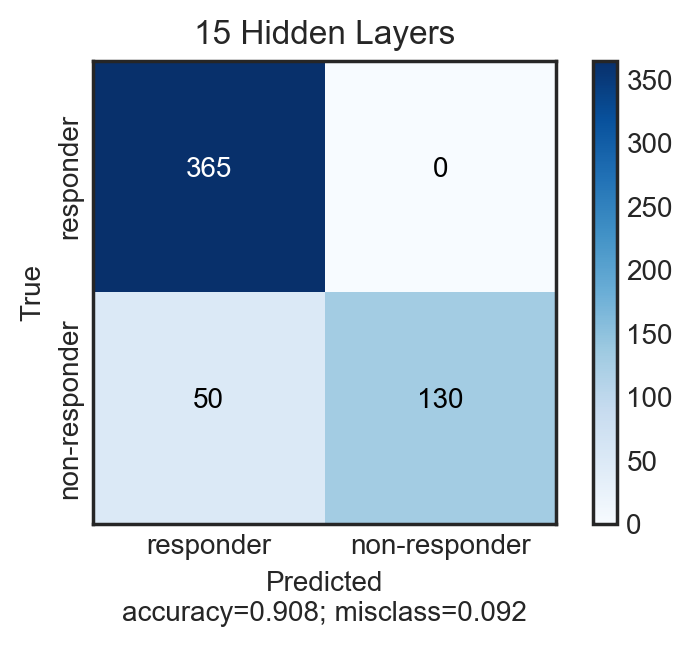

In [60]:
plt.rcParams.update({'font.size': 10})
cm_hidden15 = plot_confusion_matrix(cm15, ['responder', 'non-responder'], title='15 Hidden Layers', normalize=False)

# Comparison Plots

In [43]:
# for 1 hidden layer
tprs1 = np.array(tpr1)
mean_tprs1 = tprs1.mean(axis=0)
std1 = tprs1.std(axis=0)
tprs_upper1 = mean_tprs1 + std1 / np.sqrt(5)
tprs_lower1 = mean_tprs1 - std1 / np.sqrt(5)
auc1 = auc(base_fpr1, mean_tprs1)

In [44]:
# for 5 hidden layers
tprs5 = np.array(tprs5)
mean_tprs5 = tprs5.mean(axis=0)
std5 = tprs5.std(axis=0)
tprs_upper5 = mean_tprs5 + std5 / np.sqrt(5)
tprs_lower5 = mean_tprs5 - std5 / np.sqrt(5)
auc5 = auc(base_fpr5, mean_tprs5)

In [45]:
# for 10 hidden layers
tprs10 = np.array(tprs10)
mean_tprs10 = tprs10.mean(axis=0)
std10 = tprs10.std(axis=0)
tprs_upper10 = mean_tprs10 + std10 / np.sqrt(5)
tprs_lower10 = mean_tprs1 - std10 / np.sqrt(5)
auc10 = auc(base_fpr10, mean_tprs10)

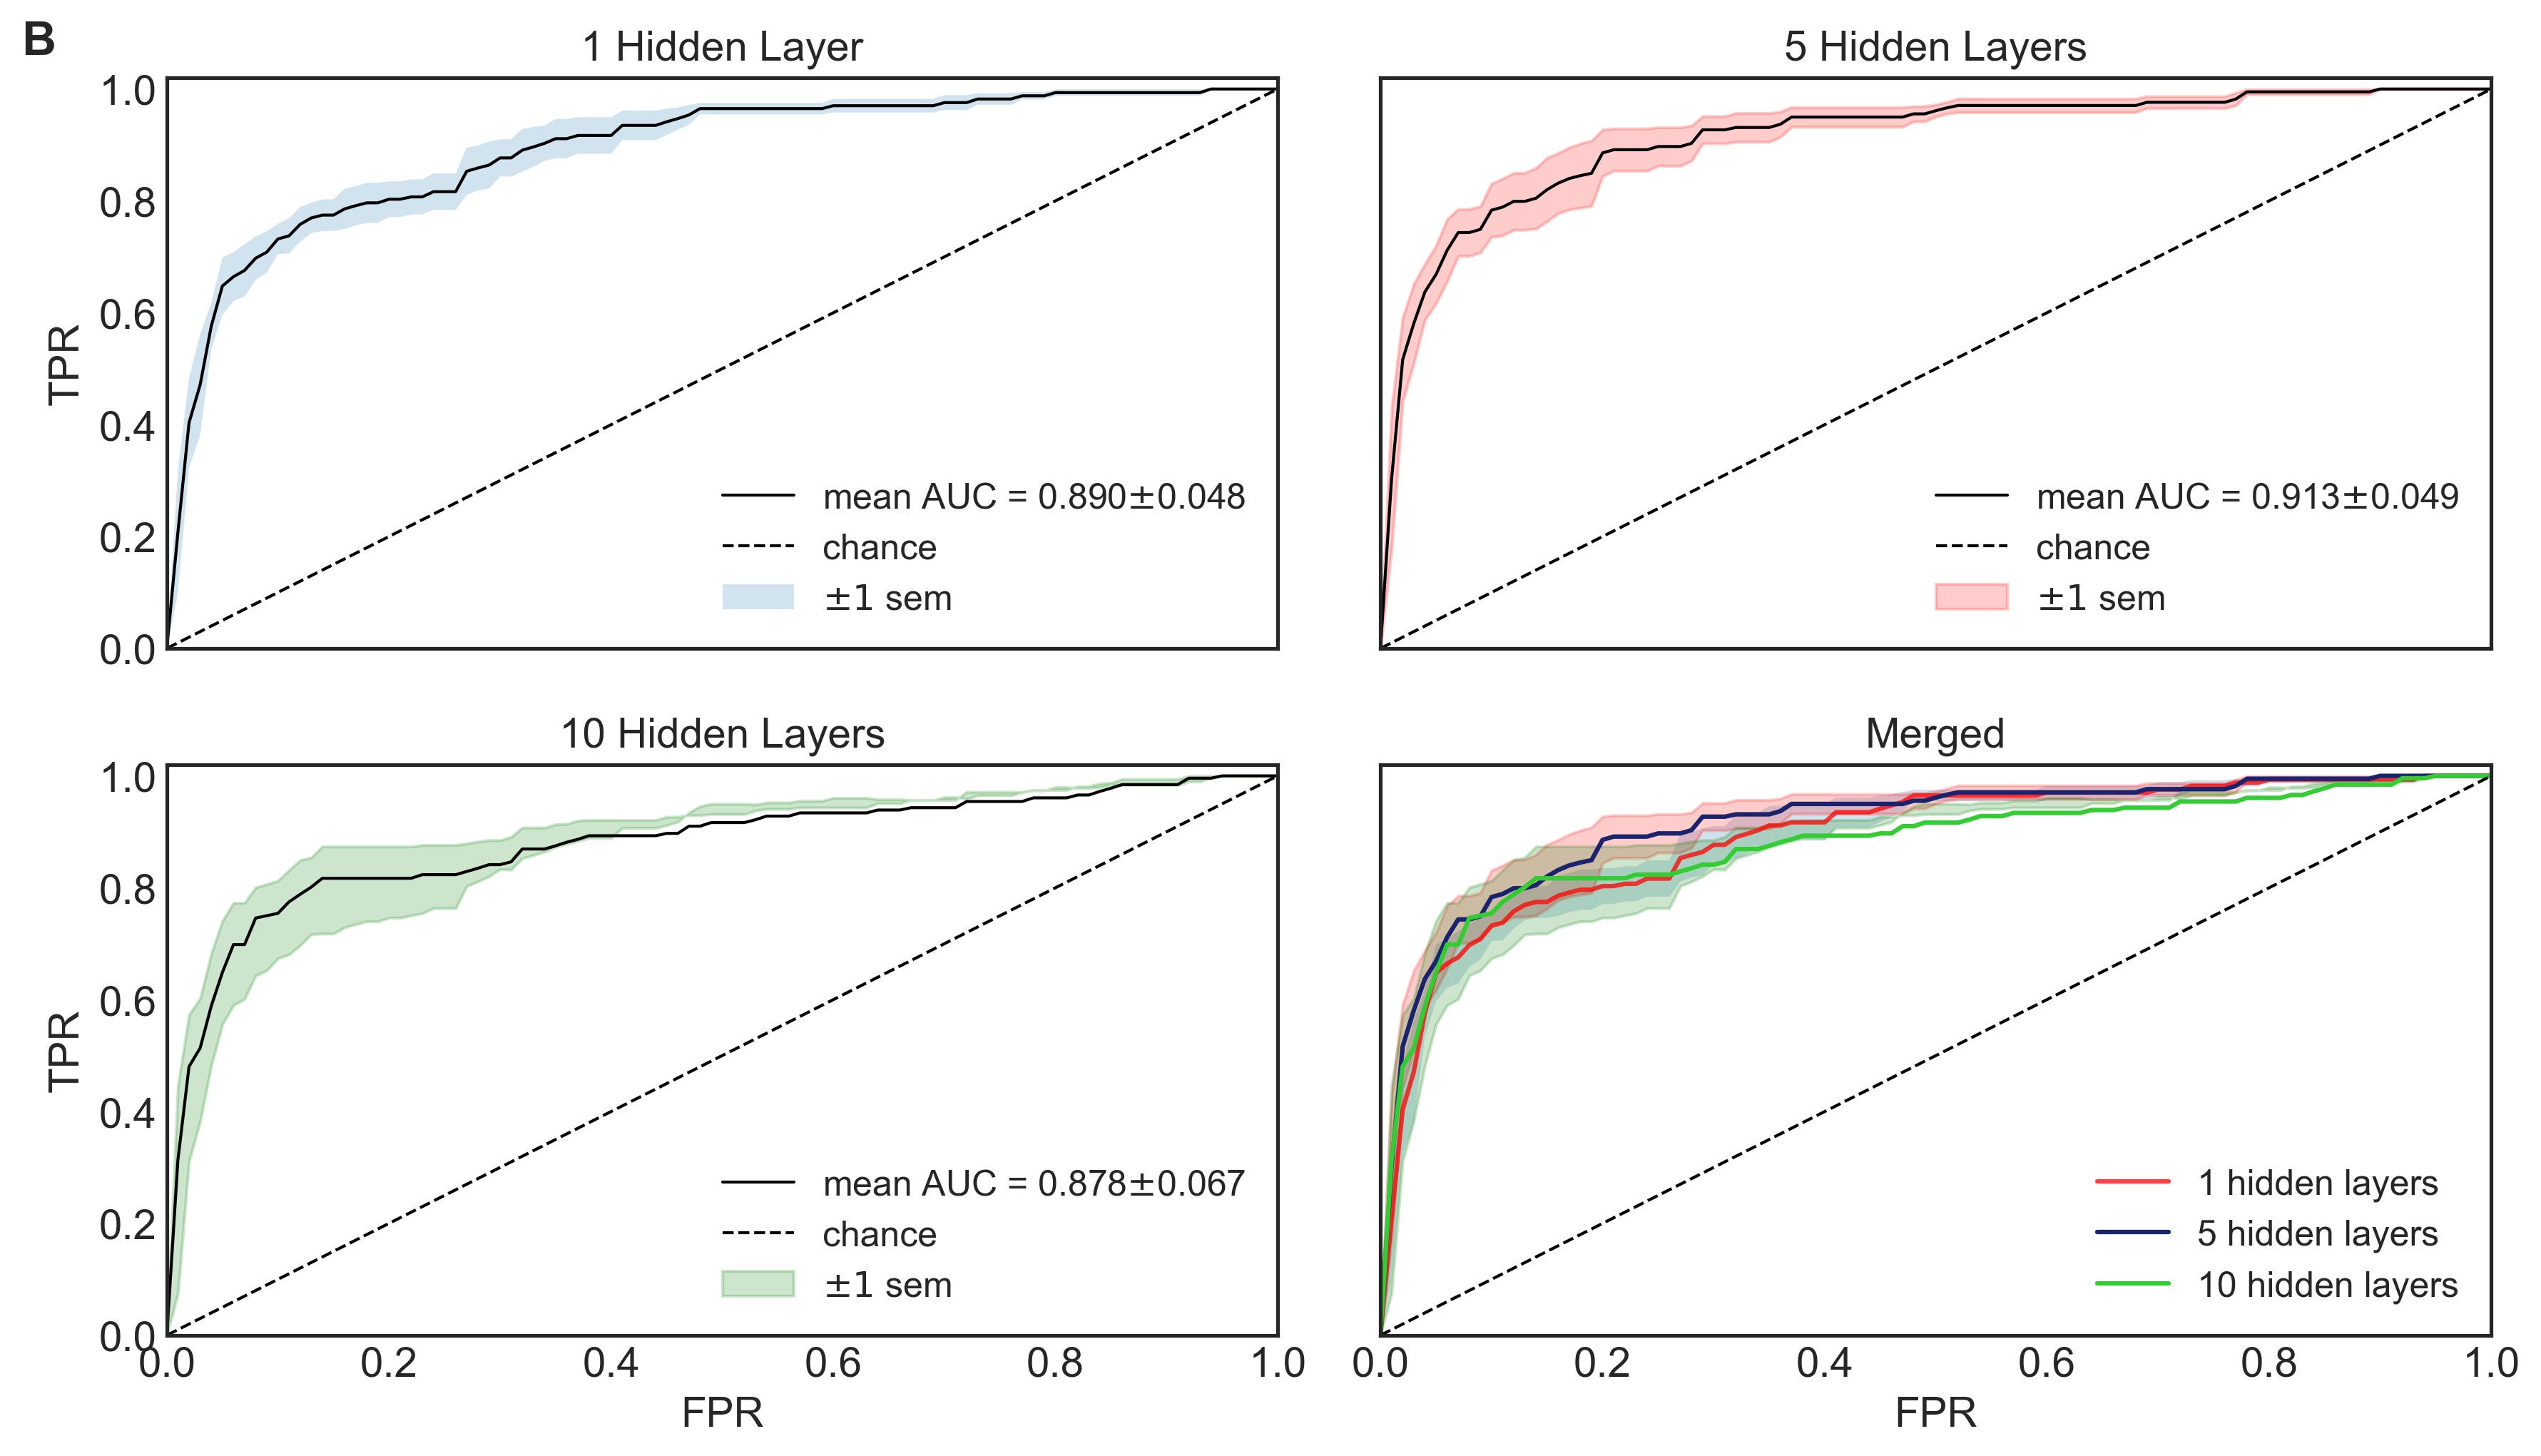

In [49]:
plt.style.use('seaborn-white')

plt.rcParams.update({'font.size': 14})
# combined figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7), dpi=300)

# 1 hidden layer
ax1.plot(base_fpr1, mean_tprs1, 'k', linewidth=1)
ax1.fill_between(base_fpr1, tprs_lower1, tprs_upper1, alpha=0.2)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1.02])
ax1.set_title('1 Hidden Layer', fontsize=14)
ax1.set_ylabel('TPR', fontsize=14)
ax1.set_xlabel('FPR', fontsize=14)
ax1.legend(['mean AUC = ' + str(round(auc1, 3)) + '$\pm$' + str(round(np.mean(std1), 3)),
            'chance', '$\pm 1$ sem'],
           fontsize=12, loc='lower right')
ax1.text(-.1, 1.1, 'B', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# 5 hidden layers
ax2.plot(base_fpr5, mean_tprs5, color='k', linewidth=1)
ax2.fill_between(base_fpr5, tprs_lower5, tprs_upper5, alpha=0.2, color='r')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1.02])
ax2.set_title('5 Hidden Layers', fontsize=14)
ax2.set_ylabel('TPR', fontsize=14)
ax2.set_xlabel('FPR', fontsize=14)
ax2.legend(['mean AUC = ' + str(round(auc5, 3)) + '$\pm$' + str(round(np.mean(std5), 3)),
            'chance', '$\pm 1$ sem'],
           fontsize=12, loc='lower right')

# 10 hidden layers
ax3.plot(base_fpr10, mean_tprs10, color='k', linewidth=1)
ax3.fill_between(base_fpr10, tprs_lower10, tprs_upper10, alpha=0.2, color='g')
ax3.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1.02])
ax3.set_title('10 Hidden Layers', fontsize=14)
ax3.set_ylabel('TPR', fontsize=14)
ax3.set_xlabel('FPR', fontsize=14)
ax3.legend(['mean AUC = ' + str(round(auc10, 3)) + '$\pm$' + str(round(np.mean(std10), 3)),
            'chance', '$\pm 1$ sem'],
           fontsize=12, loc='lower right')

# merged
## 1
ax4.plot(base_fpr1, mean_tprs1, '#ff0000', linewidth=1.5, alpha=0.75)
ax4.fill_between(base_fpr1, tprs_lower1, tprs_upper1, alpha=0.2)
## 5
ax4.plot(base_fpr5, mean_tprs5, '#1a236e', linewidth=1.5, alpha=1)
ax4.fill_between(base_fpr5, tprs_lower5, tprs_upper5, alpha=0.2, color='r')
## 10
ax4.plot(base_fpr10, mean_tprs10, '#32CD32', linewidth=1.5, alpha=1)
ax4.fill_between(base_fpr10, tprs_lower10, tprs_upper10, alpha=0.2, color='g')
ax4.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax4.set_xlim([0, 1])
ax4.set_ylim([0, 1.02])
ax4.set_title('Merged', fontsize=14)
ax4.set_ylabel('TPR', fontsize=14)
ax4.set_xlabel('FPR', fontsize=14)
ax4.legend(['1 hidden layers', '5 hidden layers', '10 hidden layers'], fontsize=12, loc='lower right')

for ax in fig.get_axes():
    ax.label_outer()
fig.tight_layout()

In [50]:
fig.savefig('figures/roc_combined.png')